In [1]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt

In [2]:
# Load data
root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-23_date-20250415/behav/2025-04-15T15-00-14')

In [3]:
# Metadata loading
metadata_reader = utils.SessionData()
session_settings = utils.load_json(metadata_reader, root/"SessionSettings")
print(session_settings.iloc[0]['metadata'].sequences)

/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-23_date-20250415/behav/2025-04-15T15-00-14/SessionSettings/SessionSettings_*.jsonl
[[{'rewardConditions': [{'definition': [[{'command': 'OdorA', 'rewarded': True}]], 'position': 0}], 'presentationTime': 1.0, 'interCommand': 'Purge', 'interCommandTime': 0.2, 'minimumEngagementTime': 0.35, 'completionRequiresEngagement': True, 'skipSampling': False, 'enableTrialIndicator': True, 'enableRewardLocationIndicator': False, 'rewardAttempts': 0, 'responseTime': 99999.0, 'interTrialInterval': 0.0, 'name': 'OdourDiscriminationA_Stage7', 'defaultCommand': 'Default', 'maximumTime': 10.0, 'resetOnReward': True}, {'rewardConditions': [{'definition': [[{'command': 'OdorB', 'rewarded': True}]], 'position': 1}], 'presentationTime': 1.0, 'interCommand': 'Purge', 'interCommandTime': 0.2, 'minimumEngagementTime': 0.35, 'completionRequiresEngagement': True, 'skipSampling': False, 'enableTrialIndicator': True, 'enableRewardLocationIndicator': False, 'rewardA

In [4]:
## Extract which stage the session is in

stage_found = None
for seq in session_settings.iloc[0]['metadata'].sequences[0]:
    if 'name' in seq:
        match = re.search(r'_Stage(\d+)', seq['name'])
        if match:
            stage_found = match.group(1)
            print(f"Session stage is: {stage_found}")
            break

Session stage is: 7


In [5]:
# Load relevant data streams
behavior_reader = harp.reader.create_reader('device_schemas/behavior.yml', epoch=harp.io.REFERENCE_EPOCH)
olfactometer_reader = harp.reader.create_reader('device_schemas/olfactometer.yml', epoch=harp.io.REFERENCE_EPOCH)

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# 'other' events
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior") # reward A pump end time
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior") # reward B pump end time
pulse_enable = utils.load(behavior_reader.OutputPulseEnable, root/"Behavior") # allow for either pump to deliver reward


In [6]:
# Convert the time column which is an index into the first column of each event dataframe

for df in [
    heartbeat,
    digital_input_data,
    output_set,
    output_clear,
    olfactometer_valves_0,
    olfactometer_valves_1,
    olfactometer_end_0,
    analog_data,
    flow_meter,
    pulse_supply_1,
    pulse_supply_2,
    pulse_enable
]:
    df.reset_index(inplace=True) # Convert the index ("Time") into a column

In [7]:
## Load experiment events data

# Directory containing the experiment event files
experiment_events_dir = root / "ExperimentEvents"

# Find all CSV files in the directory
csv_files = list(experiment_events_dir.glob('*.csv'))

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate through each CSV file and load it into a DataFrame
for csv_file in csv_files:
    try:
        print(f"Loading file: {csv_file}")
        df = pd.read_csv(csv_file)  # Load the CSV file into a DataFrame
        dataframes.append(df)  # Append the DataFrame to the list
    except Exception as e:
        print(f"Error loading file {csv_file}: {e}")

# Concatenate all DataFrames into a single DataFrame
experiment_events = pd.concat(dataframes, ignore_index=True)

# Sort experiment_events by the Seconds column in ascending order
experiment_events = experiment_events.sort_values(by='Seconds', ascending=True)

# Reset the index after sorting
experiment_events.reset_index(drop=True, inplace=True)

# Convert the Time column in heartbeat to datetime if it's not already
heartbeat['Time'] = pd.to_datetime(heartbeat['Time'])

# Create a mapping from TimestampSeconds to Time in heartbeat
timestamp_to_time = pd.Series(data=heartbeat['Time'].values, index=heartbeat['TimestampSeconds'])

# Interpolate Time for experiment_events based on Seconds
def interpolate_time(seconds):
    # Get the integer part of seconds (floor value)
    int_seconds = int(seconds)
    # Get the fractional part of seconds
    fractional_seconds = seconds % 1

    # Check if the integer part exists in the mapping
    if int_seconds in timestamp_to_time.index:
        base_time = timestamp_to_time.loc[int_seconds]
        return base_time + pd.to_timedelta(fractional_seconds, unit='s')
    else:
        # Handle cases where the integer part is out of bounds
        return pd.NaT

# Apply the interpolation function to the Seconds column
experiment_events['Time'] = experiment_events['Seconds'].apply(interpolate_time)

Loading file: /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-23_date-20250415/behav/2025-04-15T15-00-14/ExperimentEvents/ExperimentEvents_1904-01-19T00-00-00.csv
Loading file: /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-23_date-20250415/behav/2025-04-15T15-00-14/ExperimentEvents/ExperimentEvents_1904-01-18T23-00-00.csv


In [8]:
## Determine session length

# Calculate session duration in seconds
start_time_sec = heartbeat['TimestampSeconds'].iloc[0]
end_time_sec = heartbeat['TimestampSeconds'].iloc[-1]
session_duration_sec = end_time_sec - start_time_sec

# Convert to hours, minutes, seconds
hours = int(session_duration_sec // 3600)
minutes = int((session_duration_sec % 3600) // 60)
seconds = int(session_duration_sec % 60)

print(f"Session duration: {hours} hours, {minutes} minutes, {seconds} seconds")

Session duration: 1 hours, 22 minutes, 23 seconds


In [9]:
## Convert all data streams from hardware timestamps to real timestamps

# Parse real-time reference from path (e.g., "2025-03-25T15-53-02")
real_time_str = root.as_posix().split('/')[-1]
# Parse the string as UTC and add timezone info
real_time_ref_utc = datetime.datetime.strptime(real_time_str, '%Y-%m-%dT%H-%M-%S').replace(tzinfo=timezone.utc)
# Convert UTC time to UK time (Europe/London, which handles DST automatically)
uk_tz = zoneinfo.ZoneInfo("Europe/London")
real_time_ref = real_time_ref_utc.astimezone(uk_tz)

# Determine hardware start time and compute offset
start_time_hardware = heartbeat['Time'].iloc[0]  # A Pandas Timestamp
start_time_dt = start_time_hardware.to_pydatetime()  # Now a Python datetime

# If the hardware timestamp is naive, assume it is in UK time
if start_time_dt.tzinfo is None:
    start_time_dt = start_time_dt.replace(tzinfo=uk_tz)

# Finally, compute the real-time offset
real_time_offset = real_time_ref - start_time_dt

# Create absolute (real-time) dataframes
digital_input_data_abs = digital_input_data.copy()
output_set_abs = output_set.copy()
output_clear_abs = output_clear.copy()
olfactometer_valves_0_abs = olfactometer_valves_0.copy()
olfactometer_valves_1_abs = olfactometer_valves_1.copy()
olfactometer_end_0_abs = olfactometer_end_0.copy()
analog_data_abs = analog_data.copy()
flow_meter_abs = flow_meter.copy()
pulse_supply_1_abs = pulse_supply_1.copy()
pulse_supply_2_abs = pulse_supply_2.copy()
pulse_enable_abs = pulse_enable.copy()

for df_abs in [
    digital_input_data_abs,
    output_set_abs,
    output_clear_abs,
    olfactometer_valves_0_abs,
    olfactometer_valves_1_abs,
    olfactometer_end_0_abs,
    analog_data_abs,
    flow_meter_abs,
    pulse_supply_1_abs,
    pulse_supply_2_abs,
    pulse_enable_abs,
    experiment_events
]:
    df_abs['Time'] = df_abs['Time'] + real_time_offset

In [10]:
## Extract odour port event timings for initiation and exiting

# Extract all DIPort0 events
port0_events = digital_input_data_abs['DIPort0']

# Build a DataFrame for poke initiation events (TRUE)
init_poke = port0_events[port0_events == True].to_frame(name='EventValue')
init_poke['Time'] = digital_input_data_abs.loc[init_poke.index, 'Time'].values
init_poke = init_poke[['Time', 'EventValue']]  # keep only "Time" and event value

# Build a list for exit events, then convert to a DataFrame
init_poke_exit_list = []
for idx in init_poke.index:
    subsequent_false = port0_events[(port0_events.index > idx) & (port0_events == False)]
    if not subsequent_false.empty:
        next_false_idx = subsequent_false.index[0]
        next_false_time = digital_input_data_abs.loc[next_false_idx, 'Time']
        init_poke_exit_list.append({'Time': next_false_time, 'EventValue': False})

init_poke_exit = pd.DataFrame(init_poke_exit_list)

In [11]:
## Extract relevant events for reward pokes and delivery from the *abs dataframes and store 'Time' in each variable

# Port activation events
r1_poke = digital_input_data_abs[digital_input_data_abs['DIPort1'] == True].copy()
r1_poke = r1_poke[['Time', 'DIPort1']]  # Keep only Time and DIPort1

r2_poke = digital_input_data_abs[digital_input_data_abs['DIPort2'] == True].copy()
r2_poke = r2_poke[['Time', 'DIPort2']]

# Reward events
r1_reward = pulse_supply_1_abs[['Time']].copy()
r1_reward['PulseSupplyPort1'] = True

r2_reward = pulse_supply_2_abs[['Time']].copy()
r2_reward['PulseSupplyPort2'] = True

# Olfactometer valve events
r1_olf_valve = olfactometer_valves_0_abs[olfactometer_valves_0_abs['Valve0'] == True].copy()
r1_olf_valve = r1_olf_valve[['Time', 'Valve0']]

r2_olf_valve = olfactometer_valves_0_abs[olfactometer_valves_0_abs['Valve1'] == True].copy()
r2_olf_valve = r2_olf_valve[['Time', 'Valve1']]

In [12]:
## Create a unique dataframe for each experiment event so that it can be incorporated into the dataframe with all events

# Ensure experiment_events has a Time column and is sorted
experiment_events['Time'] = pd.to_datetime(experiment_events['Time'], errors='coerce')  # Ensure Time is datetime
experiment_events = experiment_events.sort_values(by='Time').reset_index(drop=True)

# Create a dictionary to store DataFrames for each unique Value
experiment_event_dataframes = {}

# Iterate through each unique Value in experiment_events
for event_value in experiment_events['Value'].unique():
    # Filter rows for the current event_value
    event_df = experiment_events[experiment_events['Value'] == event_value][['Time']].copy()
    # Add a column with True for the event
    event_df[event_value] = True
    # Set Time as the index
    event_df.set_index('Time', inplace=True)
    # Store the DataFrame in the dictionary
    experiment_event_dataframes[event_value] = event_df

# Convert the Time index to a column for all DataFrames and save as unique DataFrames
for event_value, df in experiment_event_dataframes.items():
    # Reset the index to make Time a column
    df = df.reset_index()  # Reset index to make Time a column
    # Dynamically assign each DataFrame to a variable in the global namespace
    globals()[f"{event_value}_df"] = df
    print(f"DataFrame for event '{event_value}' saved as '{event_value}_df'")
    print(df.head())

DataFrame for event 'EndInitiation' saved as 'EndInitiation_df'
                        Time  EndInitiation
0 2025-04-15 16:01:29.725984           True
1 2025-04-15 16:01:36.314976           True
2 2025-04-15 16:01:45.172992           True
3 2025-04-15 16:01:49.594976           True
4 2025-04-15 16:02:32.988992           True
DataFrame for event 'AwaitReward' saved as 'AwaitReward_df'
                        Time  AwaitReward
0 2025-04-15 16:01:29.737984         True
1 2025-04-15 16:01:36.316992         True
2 2025-04-15 16:01:45.174976         True
3 2025-04-15 16:01:49.597984         True
4 2025-04-15 16:02:32.990976         True
DataFrame for event 'Reset' saved as 'Reset_df'
                        Time  Reset
0 2025-04-15 16:01:31.202976   True
1 2025-04-15 16:01:37.541984   True
2 2025-04-15 16:01:47.476992   True
3 2025-04-15 16:01:51.064000   True
4 2025-04-15 16:02:34.018976   True
DataFrame for event 'InitiationSequence' saved as 'InitiationSequence_df'
                      

In [13]:
## Create a DataFrame with all events

def create_unique_series(events_df):
    """Creates a unique-timestamp boolean series (event = True) from a DataFrame that has a Time column."""
    timestamps = events_df['Time']
    # Handle duplicates by adding microsecond offsets
    if len(timestamps) != len(set(timestamps)):
        unique_timestamps = []
        seen = set()
        for ts in timestamps:
            counter = 0
            ts_modified = ts
            while ts_modified in seen:
                counter += 1
                ts_modified = ts + pd.Timedelta(microseconds=counter)
            seen.add(ts_modified)
            unique_timestamps.append(ts_modified)
        timestamps = unique_timestamps
    return pd.Series(True, index=timestamps)

# Example: create Series from various *abs dataframes (already in real-time)
init_poke_series    = create_unique_series(init_poke)
r1_poke_series      = create_unique_series(r1_poke)
r2_poke_series      = create_unique_series(r2_poke)
r1_reward_series    = create_unique_series(r1_reward)
r2_reward_series    = create_unique_series(r2_reward)
r1_olf_valve_series = create_unique_series(r1_olf_valve)
r2_olf_valve_series = create_unique_series(r2_olf_valve)
EndInitiation_df_series = create_unique_series(EndInitiation_df)
AwaitReward_df_series = create_unique_series(AwaitReward_df)
Reset_df_series = create_unique_series(Reset_df)
ChooseRandomSequence_df_series = create_unique_series(ChooseRandomSequence_df)
SampleRewardCondition_df_series = create_unique_series(SampleRewardCondition_df)
InitiationSequence_df_series = create_unique_series(InitiationSequence_df)

# Combine into a single DataFrame
events_df = pd.DataFrame({
    'init_poke': init_poke_series,
    'r1_poke': r1_poke_series,
    'r2_poke': r2_poke_series,
    'r1_reward': r1_reward_series,
    'r2_reward': r2_reward_series,
    'r1_olf_valve': r1_olf_valve_series,
    'r2_olf_valve': r2_olf_valve_series,
    'EndInitiation': EndInitiation_df_series,
    'AwaitReward': AwaitReward_df_series,
    'Reset': Reset_df_series,
    'ChooseRandomSequence': ChooseRandomSequence_df_series,
    'SampleRewardCondition': SampleRewardCondition_df_series,
    'InitiationSequence': InitiationSequence_df_series
})

# Convert the index (real-time Timestamps) to a column
events_df = events_df.reset_index(names='timestamp')

# Convert 'timestamp' column to datetime and localize tz-naive timestamps to UK time
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], errors='coerce')
events_df['timestamp'] = events_df['timestamp'].apply(
    lambda ts: ts if ts.tzinfo is not None else ts.replace(tzinfo=uk_tz)
)

# Drop rows with invalid timestamps (if any)
events_df = events_df.dropna(subset=['timestamp'])

# Fill missing event columns with False and sort
events_df = events_df.fillna(False).sort_values('timestamp')

# Mark start_time from real_time_ref
events_df['start_time'] = False
start_time = real_time_ref  # use your existing real_time_ref here

start_time_row = pd.DataFrame({
    'timestamp': [start_time],
    'init_poke': [False],
    'r1_poke': [False],
    'r2_poke': [False],
    'r1_reward': [False],
    'r2_reward': [False],
    'r1_olf_valve': [False],
    'r2_olf_valve': [False],
    'EndInitiation': [False],
    'AwaitReward': [False],
    'Reset': [False],
    'ChooseRandomSequence': [False],
    'SampleRewardCondition': [False],
    'InitiationSequence': [False],
    'start_time': [True]
})

# Ensure start_time_row has the same column order as events_df
start_time_row = start_time_row[events_df.columns]

# Concatenate start_time_row with events_df
events_df_adjusted = pd.concat([start_time_row, events_df], ignore_index=True).sort_values('timestamp')

# Remove timezone info from the 'timestamp' column so it displays as naive datetime
events_df_adjusted['timestamp'] = events_df_adjusted['timestamp'].dt.tz_localize(None)

# Display the adjusted DataFrame
display(events_df_adjusted)

/var/folders/_n/p_b9638x5g99dbmz8kz99s100000gn/T/ipykernel_4895/2095195993.py:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_df = events_df.fillna(False).sort_values('timestamp')


,timestamp,init_poke,r1_poke,r2_poke,r1_reward,r2_reward,r1_olf_valve,r2_olf_valve,EndInitiation,AwaitReward,Reset,ChooseRandomSequence,SampleRewardCondition,InitiationSequence,start_time
0,2025-04-15 16:00:14.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2025-04-15 16:00:38.532608,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,2025-04-15 16:00:51.610144,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2025-04-15 16:00:51.630720,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,2025-04-15 16:00:57.303136,False,True,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,2025-04-15 17:22:28.135296,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4235,2025-04-15 17:22:28.199488,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4236,2025-04-15 17:22:30.029280,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4237,2025-04-15 17:22:37.585088,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
def calculate_overall_decision_accuracy(events_df):
    """
    Calculate decision accuracy for the entire session:
    - Determine index of EndInitiation = True
    - Go back to find the closest r1_olf_valve or r2_olf_valve = True
    - If closest is r1_olf_valve, it is an r1 trial; check if the next r1_poke or r2_poke is correct
    - If closest is r2_olf_valve, it is an r2 trial; check if the next r1_poke or r2_poke is correct
    """
    # Make sure the dataframe is sorted by timestamp
    events_df = events_df.sort_values('timestamp')
    
    # Reset index for easier sequential analysis
    data = events_df.reset_index(drop=True)
    
    r1_correct = 0
    r1_total = 0
    r2_correct = 0
    r2_total = 0
    
    # Find all indices where EndInitiation = True
    end_initiation_indices = data.index[data['EndInitiation'] == True].tolist()
    
    for end_idx in end_initiation_indices:
        # Go back to find the closest r1_olf_valve or r2_olf_valve = True
        closest_valve_idx = None
        for i in range(end_idx - 1, -1, -1):  # Iterate backward
            if data.loc[i, 'r1_olf_valve']:
                closest_valve_idx = i
                trial_type = 'r1'
                break
            elif data.loc[i, 'r2_olf_valve']:
                closest_valve_idx = i
                trial_type = 'r2'
                break
        
        # If no valve was found, skip this EndInitiation
        if closest_valve_idx is None:
            continue
        
        # Increment the total count for the trial type
        if trial_type == 'r1':
            r1_total += 1
        elif trial_type == 'r2':
            r2_total += 1
        
        # Look ahead for the next poke after EndInitiation
        for j in range(end_idx + 1, len(data)):
            if data.loc[j, 'r1_poke'] or data.loc[j, 'r2_poke']:
                # Found a poke, was it the correct one?
                if trial_type == 'r1' and data.loc[j, 'r1_poke']:
                    r1_correct += 1
                elif trial_type == 'r2' and data.loc[j, 'r2_poke']:
                    r2_correct += 1
                break
    
    # Calculate percentages
    r1_accuracy = (r1_correct / r1_total * 100) if r1_total > 0 else 0
    r2_accuracy = (r2_correct / r2_total * 100) if r2_total > 0 else 0
    overall_accuracy = ((r1_correct + r2_correct) / (r1_total + r2_total) * 100) if (r1_total + r2_total) > 0 else 0
    
    # Create a summary dictionary
    summary = {
        'r1_total': r1_total,
        'r1_correct': r1_correct,
        'r1_accuracy': r1_accuracy,
        'r2_total': r2_total,
        'r2_correct': r2_correct,
        'r2_accuracy': r2_accuracy,
        'total_trials': r1_total + r2_total,
        'total_correct': r1_correct + r2_correct,
        'overall_accuracy': overall_accuracy
    }
    
    return summary

# Calculate overall session accuracy
session_accuracy = calculate_overall_decision_accuracy(events_df_adjusted)

# Display results as a nicely formatted summary
print("Session Decision Accuracy Summary:")
print(f"R1 Trials: {session_accuracy['r1_total']} (Correct: {session_accuracy['r1_correct']}, Accuracy: {session_accuracy['r1_accuracy']:.2f}%)")
print(f"R2 Trials: {session_accuracy['r2_total']} (Correct: {session_accuracy['r2_correct']}, Accuracy: {session_accuracy['r2_accuracy']:.2f}%)")
print(f"Overall: {session_accuracy['total_trials']} trials, {session_accuracy['total_correct']} correct, Accuracy: {session_accuracy['overall_accuracy']:.2f}%")

# Create a pandas DataFrame for easier display in notebook
session_df = pd.DataFrame([session_accuracy])
display(session_df[['r1_total', 'r1_correct', 'r1_accuracy', 'r2_total', 'r2_correct', 'r2_accuracy', 'overall_accuracy']])

Session Decision Accuracy Summary:
R1 Trials: 164 (Correct: 158, Accuracy: 96.34%)
R2 Trials: 162 (Correct: 128, Accuracy: 79.01%)
Overall: 326 trials, 286 correct, Accuracy: 87.73%


,r1_total,r1_correct,r1_accuracy,r2_total,r2_correct,r2_accuracy,overall_accuracy
0,164,158,96.341463,162,128,79.012346,87.730061


In [15]:
## Time spent in odour port within a session - average and standard deviation

# Ensure init_poke and init_poke_exit have the same length/use the min length
common_len = min(len(init_poke), len(init_poke_exit))

# Calculate time spent (exit minus initiation)
time_spent = init_poke_exit["Time"].iloc[:common_len].values - init_poke["Time"].iloc[:common_len].values

# Convert to seconds
time_spent_seconds = time_spent / np.timedelta64(1, 's')

# Compute mean and std
mean_time_spent = time_spent_seconds.mean()
std_time_spent = time_spent_seconds.std()

print(f"Mean time spent in odour port: {mean_time_spent:.3f} seconds")
print(f"Standard deviation: {std_time_spent:.3f} seconds")

Mean time spent in odour port: 0.181 seconds
Standard deviation: 0.113 seconds


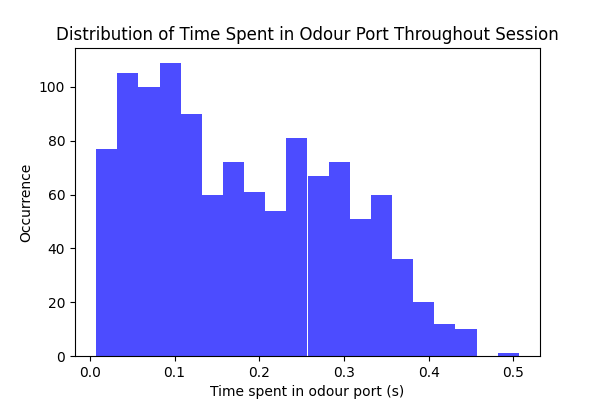

In [22]:
## Time spent in odour port distribution - histogram

# Suppose we already have time_spent_seconds (from the difference in init_poke vs init_poke_exit)

plt.figure(figsize=(6, 4))
plt.hist(time_spent_seconds, bins=20, color='blue', alpha=0.7)
plt.xlabel('Time spent in odour port (s)')
plt.ylabel('Occurrence')
plt.title('Distribution of Time Spent in Odour Port Throughout Session')
plt.show()

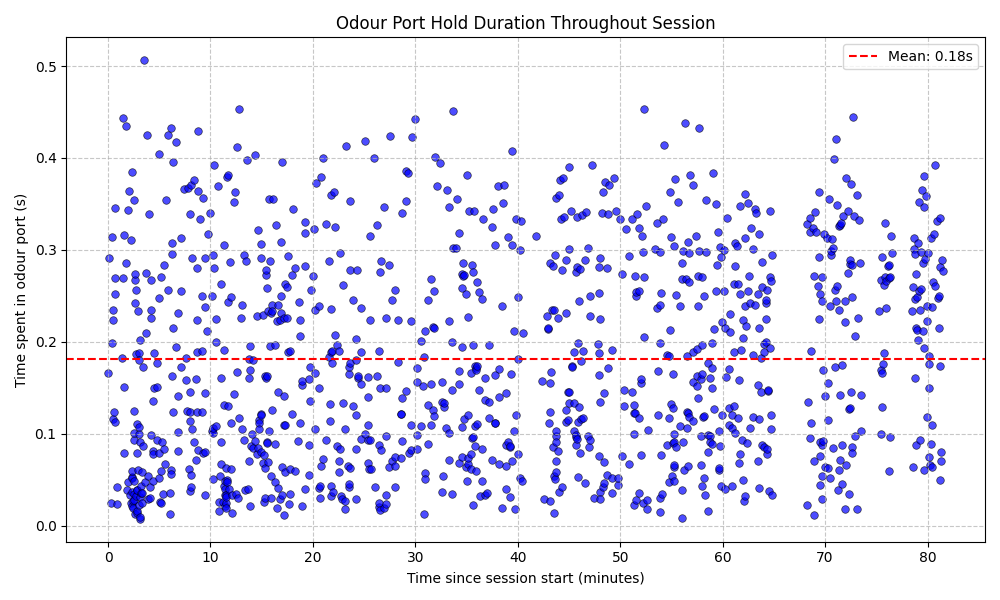

In [17]:
## Time spent in odour port distribution - odour port hold vs time

# Calculate time since session started for each poke (in minutes)
time_since_start_min = [(t - init_poke["Time"].iloc[0]).total_seconds() / 60.0
                        for t in init_poke["Time"].iloc[:common_len]]

plt.figure(figsize=(10, 6))
plt.scatter(time_since_start_min, time_spent_seconds, alpha=0.7, s=30, 
            color='blue', edgecolor='black', linewidth=0.5)
plt.xlabel('Time since session start (minutes)')
plt.ylabel('Time spent in odour port (s)')
plt.title('Odour Port Hold Duration Throughout Session')
plt.grid(True, linestyle='--', alpha=0.7)

# Add average line
plt.axhline(y=mean_time_spent, color='red', linestyle='--', 
           label=f'Mean: {mean_time_spent:.2f}s')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
## Determine response times based on valve openings and subsequent pokes

# Function to find the next event after a specified timestamp
def find_next_event(df, timestamp, event_columns):
    """
    Find the first event (from specified columns) that occurs after a given timestamp.
    Returns the event time and column name.
    """
    # Filter events after the timestamp
    future_events = df[df['timestamp'] > timestamp]
    
    if future_events.empty:
        return None, None
    
    # Find the first occurrence of any of the specified events
    for idx, row in future_events.iterrows():
        for col in event_columns:
            if row[col]:
                return row['timestamp'], col
    
    return None, None

# Lists to store response times
r1_response_times = []
r2_response_times = []

# Process each r1 odor valve event
for idx, row in events_df_adjusted[events_df_adjusted['r1_olf_valve']].iterrows():
    valve_time = row['timestamp']
    next_poke_time, poke_type = find_next_event(events_df_adjusted, valve_time, ['r1_poke', 'r2_poke'])
    
    if next_poke_time is not None:
        response_time = (next_poke_time - valve_time).total_seconds()
        r1_response_times.append({
            'response_time': response_time,
            'poke_type': poke_type
        })

# Process each r2 odor valve event
for idx, row in events_df_adjusted[events_df_adjusted['r2_olf_valve']].iterrows():
    valve_time = row['timestamp']
    next_poke_time, poke_type = find_next_event(events_df_adjusted, valve_time, ['r1_poke', 'r2_poke'])
    
    if next_poke_time is not None:
        response_time = (next_poke_time - valve_time).total_seconds()
        r2_response_times.append({
            'response_time': response_time,
            'poke_type': poke_type
        })

# Create DataFrames
r1_df = pd.DataFrame(r1_response_times)
r2_df = pd.DataFrame(r2_response_times)

# Calculate averages
if not r1_df.empty:
    r1_mean = r1_df['response_time'].mean()
    r1_std = r1_df['response_time'].std()
    r1_correct = r1_df[r1_df['poke_type'] == 'r1_poke'].shape[0]
    r1_incorrect = r1_df[r1_df['poke_type'] == 'r2_poke'].shape[0]
    r1_accuracy = r1_correct / (r1_correct + r1_incorrect) if (r1_correct + r1_incorrect) > 0 else 0
    print(f"R1 valve trials: {len(r1_df)}")
    print(f"  Mean response time: {r1_mean:.2f}s ± {r1_std:.2f}s")
    print(f"  Accuracy: {r1_accuracy:.2%} ({r1_correct} correct, {r1_incorrect} incorrect)")
else:
    print("No R1 valve trials found")

if not r2_df.empty:
    r2_mean = r2_df['response_time'].mean()
    r2_std = r2_df['response_time'].std()
    r2_correct = r2_df[r2_df['poke_type'] == 'r2_poke'].shape[0]
    r2_incorrect = r2_df[r2_df['poke_type'] == 'r1_poke'].shape[0]
    r2_accuracy = r2_correct / (r2_correct + r2_incorrect) if (r2_correct + r2_incorrect) > 0 else 0
    print(f"R2 valve trials: {len(r2_df)}")
    print(f"  Mean response time: {r2_mean:.2f}s ± {r2_std:.2f}s")
    print(f"  Accuracy: {r2_accuracy:.2%} ({r2_correct} correct, {r2_incorrect} incorrect)")
else:
    print("No R2 valve trials found")

# Overall statistics
total_trials = len(r1_df) + len(r2_df)
if total_trials > 0:
    all_times = list(r1_df['response_time']) + list(r2_df['response_time'])
    overall_mean = sum(all_times) / len(all_times)
    overall_std = np.std(all_times)
    print(f"\nOverall response time: {overall_mean:.2f}s ± {overall_std:.2f}s")
    print(f"Total trials: {total_trials}")
else:
    print("No trials found")


R1 valve trials: 349
  Mean response time: 2.30s ± 1.00s
  Accuracy: 93.70% (327 correct, 22 incorrect)
R2 valve trials: 368
  Mean response time: 2.21s ± 1.38s
  Accuracy: 70.92% (261 correct, 107 incorrect)

Overall response time: 2.25s ± 1.21s
Total trials: 717


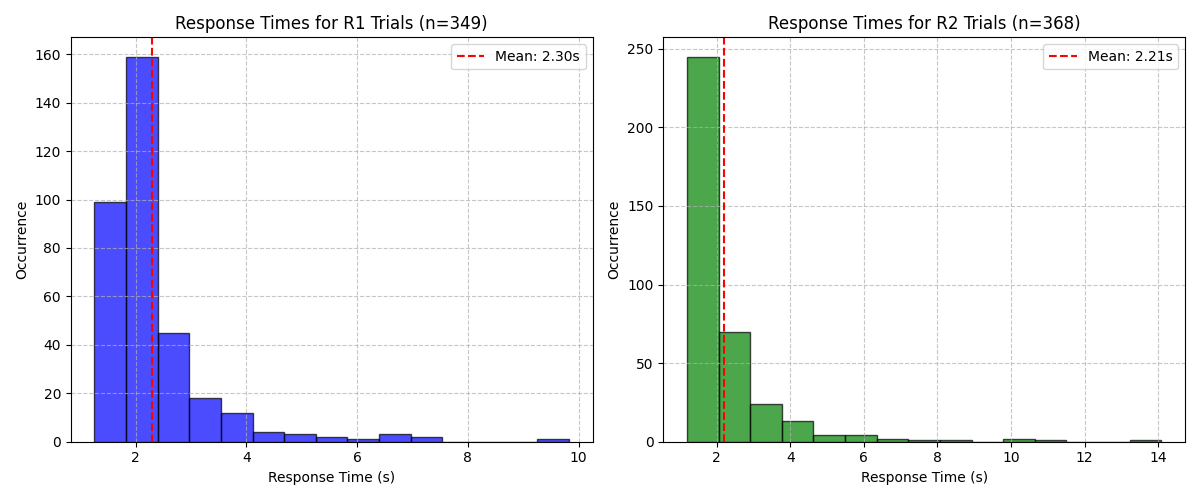

In [24]:
## Plot histograms of response times for R1 and R2 trials

plt.figure(figsize=(12, 5))

# R1 trials histogram
plt.subplot(1, 2, 1)
if not r1_df.empty:
    plt.hist(r1_df['response_time'], bins=15, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(x=r1_mean, color='red', linestyle='--', 
               label=f'Mean: {r1_mean:.2f}s')
    plt.legend()
    plt.title(f'Response Times for R1 Trials (n={len(r1_df)})')
else:
    plt.text(0.5, 0.5, 'No R1 trials data', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Response Times for R1 Trials')
plt.xlabel('Response Time (s)')
plt.ylabel('Occurrence')
plt.grid(True, linestyle='--', alpha=0.7)

# R2 trials histogram
plt.subplot(1, 2, 2)
if not r2_df.empty:
    plt.hist(r2_df['response_time'], bins=15, color='green', alpha=0.7, edgecolor='black')
    plt.axvline(x=r2_mean, color='red', linestyle='--', 
               label=f'Mean: {r2_mean:.2f}s')
    plt.legend()
    plt.title(f'Response Times for R2 Trials (n={len(r2_df)})')
else:
    plt.text(0.5, 0.5, 'No R2 trials data', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Response Times for R2 Trials')
plt.xlabel('Response Time (s)')
plt.ylabel('Occurrence')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [20]:
## Analyze response times for correct trials (matching valve and poke)

# Filter for correct responses only
r1_correct_df = r1_df[r1_df['poke_type'] == 'r1_poke']
r2_correct_df = r2_df[r2_df['poke_type'] == 'r2_poke']

# Calculate statistics for correct R1 trials
if not r1_correct_df.empty:
    r1_correct_mean = r1_correct_df['response_time'].mean()
    r1_correct_std = r1_correct_df['response_time'].std()
    print(f"R1 correct trials (n={len(r1_correct_df)}): {r1_correct_mean:.2f}s ± {r1_correct_std:.2f}s")
else:
    print("No correct R1 trials found")

# Calculate statistics for correct R2 trials
if not r2_correct_df.empty:
    r2_correct_mean = r2_correct_df['response_time'].mean()
    r2_correct_std = r2_correct_df['response_time'].std()
    print(f"R2 correct trials (n={len(r2_correct_df)}): {r2_correct_mean:.2f}s ± {r2_correct_std:.2f}s")
else:
    print("No correct R2 trials found")

# Overall correct trials statistics
correct_trials = pd.concat([r1_correct_df, r2_correct_df])
if not correct_trials.empty:
    overall_correct_mean = correct_trials['response_time'].mean()
    overall_correct_std = correct_trials['response_time'].std()
    print(f"\nOverall correct trials (n={len(correct_trials)}): {overall_correct_mean:.2f}s ± {overall_correct_std:.2f}s")
    
    # Calculate percent correct
    total_trials = len(r1_df) + len(r2_df)
    percent_correct = (len(correct_trials) / total_trials) * 100 if total_trials > 0 else 0
    print(f"Accuracy: {percent_correct:.1f}% ({len(correct_trials)}/{total_trials})")
else:
    print("No correct trials found")

R1 correct trials (n=327): 2.28s ± 0.97s
R2 correct trials (n=261): 2.06s ± 1.15s

Overall correct trials (n=588): 2.18s ± 1.06s
Accuracy: 82.0% (588/717)


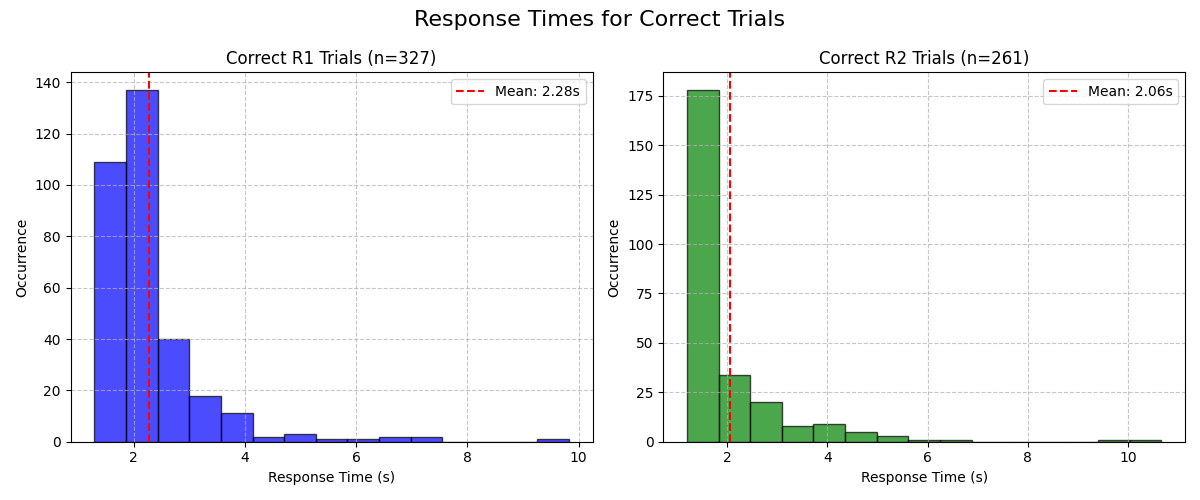

In [25]:
## Plot histograms of response times for correct trials only

plt.figure(figsize=(12, 5))

# R1 correct trials histogram
plt.subplot(1, 2, 1)
if not r1_correct_df.empty:
    plt.hist(r1_correct_df['response_time'], bins=15, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(x=r1_correct_mean, color='red', linestyle='--', 
               label=f'Mean: {r1_correct_mean:.2f}s')
    plt.legend()
    plt.title(f'Correct R1 Trials (n={len(r1_correct_df)})')
else:
    plt.text(0.5, 0.5, 'No correct R1 trials data', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Correct R1 Trials')
plt.xlabel('Response Time (s)')
plt.ylabel('Occurrence')
plt.grid(True, linestyle='--', alpha=0.7)

# R2 correct trials histogram
plt.subplot(1, 2, 2)
if not r2_correct_df.empty:
    plt.hist(r2_correct_df['response_time'], bins=15, color='green', alpha=0.7, edgecolor='black')
    plt.axvline(x=r2_correct_mean, color='red', linestyle='--', 
               label=f'Mean: {r2_correct_mean:.2f}s')
    plt.legend()
    plt.title(f'Correct R2 Trials (n={len(r2_correct_df)})')
else:
    plt.text(0.5, 0.5, 'No correct R2 trials data', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Correct R2 Trials')
plt.xlabel('Response Time (s)')
plt.ylabel('Occurrence')
plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Response Times for Correct Trials', fontsize=16)
plt.tight_layout()
plt.show()